In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from sklearn.model_selection import train_test_split
%pylab inline
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from IPython.display import clear_output

plt.rcParams["figure.figsize"] = (10,7)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## 1) Реализация линейной регрессии и демонстрация работы на искусственном примере.


In [2]:
class LinReg:

    def __init__(self, plot_train_loss=False, lr=1e-3, num_steps=250):
      self.plot_train_loss = plot_train_loss
      self.lr = lr
      self.num_steps = num_steps

    def fit(self, X, y):
      
      # add a column of ones for the bias term
      X_with_bias = np.c_[np.ones((X.shape[0], 1)), X]

      w = np.random.uniform(-2, 2, X_with_bias.shape[1]) - 0.5
      w_list = [w]
      loss_list = []

      for i in tqdm(range(self.num_steps)):
          w -= 2 * self.lr * X_with_bias.T.dot((X_with_bias.dot(w) - y)) / y.size
          w_list.append(w)

          loss = np.mean(np.power(np.dot(X_with_bias, w) - y, 2))
          loss_list.append(loss)

          if self.plot_train_loss:
              clear_output(True)
              plt.plot(loss_list)
              plt.show()

      self.coef_ = w_list[-1][1:]
      self.intercept_ = w_list[-1][0]
      self.w_best = w_list[-1]

    def predict(self, X):
        X_with_bias = np.c_[np.ones((X.shape[0], 1)), X]
        return X_with_bias.dot(self.w_best)

Пример:

(0.0, 2.0, 0.0, 15.0)

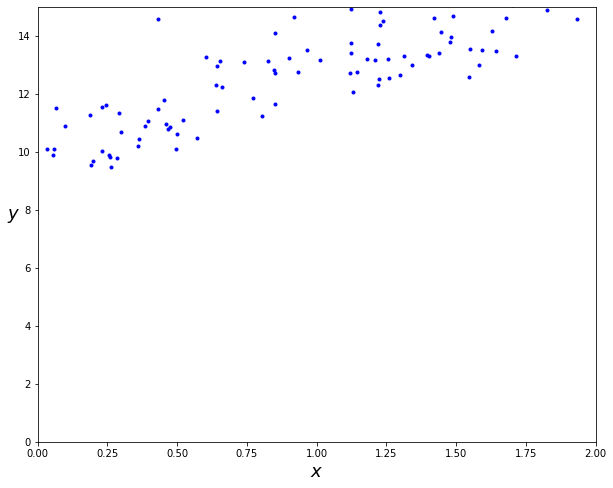

In [5]:
X_tr = 2 * np.random.rand(100, 1)
y = 10 + 3 * X_tr + np.random.randn(100, 1)

plt.figure(figsize=(10, 8))
plt.plot(X_tr, y, "b.")
plt.xlabel("$x$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])

Linear Regression with Gradient Descent:

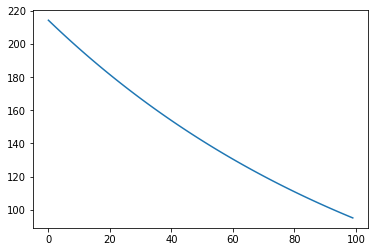

100%|██████████| 100/100 [00:18<00:00,  5.34it/s]


In [6]:
lin_reg = LinReg(plot_train_loss=True, num_steps=100)
lin_reg.fit(X_tr, y.squeeze())

**<font color=blue>Observations:</font>**
- To speed up training just turn off plotting: `plot_train_loss=False`.

Let's check the value of $w$ obtained with GD with the exact solution $w_{\text{matrix}}$ obtained with the Normal Equation:

In [7]:
X_tr_with_bias = np.c_[np.ones((100, 1)), X_tr]
w_matrix = np.linalg.inv(X_tr_with_bias.T.dot(X_tr_with_bias)).dot(X_tr_with_bias.T).dot(y)

In [8]:
print('w from normal equation: {}\nw from gradient descent: {}'.format(w_matrix.squeeze(), lin_reg.w_best))

w from normal equation: [9.99431587 2.92432257]
w from gradient descent: [1.35534701 1.86547278]


In [9]:
X_tst = np.array([[0], [2]])
X_tst_with_bias = np.c_[np.ones((2, 1)), X_tst]

y_pred_from_matrix = X_tst_with_bias.dot(w_matrix)

(0.0, 2.0, 0.0, 15.0)

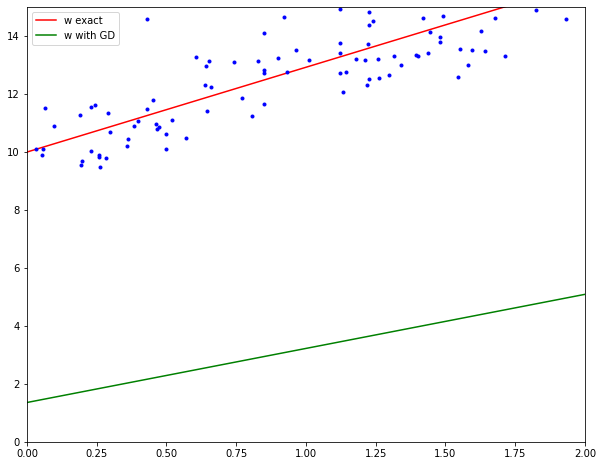

In [10]:
plt.figure(figsize=(10, 8))
plt.plot(X_tst, y_pred_from_matrix, "r-", label='w exact')
plt.plot(X_tst, lin_reg.predict(X_tst), "g-", label='w with GD')
plt.plot(X_tr, y, "b.")
plt.legend(loc="upper left")
plt.axis([0, 2, 0, 15])

## 2) Предобработка и разбиение датасета.

In [11]:
#get data
!wget https://raw.githubusercontent.com/Data-Science-FMI/ml-from-scratch-2019/master/data/house_prices_train.csv
!wget https://raw.githubusercontent.com/Data-Science-FMI/ml-from-scratch-2019/master/data/house_prices_test.csv

--2021-12-07 05:56:04--  https://raw.githubusercontent.com/Data-Science-FMI/ml-from-scratch-2019/master/data/house_prices_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460676 (450K) [text/plain]
Saving to: ‘house_prices_train.csv’

house_prices_train. 100%[===================>] 449.88K  --.-KB/s    in 0.04s   

2021-12-07 05:56:04 (11.5 MB/s) - ‘house_prices_train.csv’ saved [460676/460676]

--2021-12-07 05:56:04--  https://raw.githubusercontent.com/Data-Science-FMI/ml-from-scratch-2019/master/data/house_prices_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP 

In [12]:
df = pd.read_csv('house_prices_train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [13]:
num_features = ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 
                'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 
                '1stFlrSF','2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 
                'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 
                'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 
                'GarageCars', 'GarageArea', 'WoodDeckSF','OpenPorchSF', 
                'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 
                'MiscVal', 'MoSold', 'YrSold']

target = 'SalePrice'

Разбиение (уже было сделано):

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df[num_features], df['SalePrice'], test_size=0.2)

In [15]:
X_train

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
244,60,NaN,8880,7,5,1994,2002,0.0,1222,888,0,2110,1,0,2,1,3,1,8,2,1994.0,2,463,0,130,0,0,0,0,0,5,2010
542,20,78.0,10140,7,5,1998,1999,0.0,1680,0,0,1680,1,0,2,0,3,1,7,1,1998.0,2,583,78,73,0,0,0,0,0,6,2009
474,120,41.0,5330,8,5,2000,2000,0.0,1652,0,0,1652,1,0,2,0,2,1,6,0,2000.0,2,499,96,48,0,0,0,0,0,8,2007
619,60,85.0,12244,8,5,2003,2003,226.0,1482,780,0,2262,1,0,2,1,4,1,10,2,2003.0,3,749,168,0,0,0,0,0,0,8,2008
546,50,70.0,8737,6,7,1923,1950,0.0,915,720,0,1635,0,0,1,1,3,1,6,1,1950.0,2,440,0,38,0,144,0,0,0,5,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1148,50,NaN,5700,7,7,1926,1950,0.0,572,539,0,1111,0,0,1,0,2,1,5,1,1982.0,1,288,0,0,176,0,0,0,0,8,2008
1145,50,52.0,6240,5,6,1928,1950,0.0,1042,534,0,1576,0,0,1,0,3,1,8,1,1928.0,1,225,0,0,0,0,0,0,0,8,2006
1412,90,60.0,7200,4,5,1949,1950,0.0,1040,0,0,1040,0,0,2,0,2,2,6,0,1956.0,2,420,0,0,0,0,0,0,0,6,2009
477,60,105.0,13693,9,5,2006,2006,772.0,2069,574,0,2643,0,0,2,1,3,1,9,1,2006.0,3,694,414,84,0,0,0,0,0,3,2007


Fill `NaN`'s (уже было сделано):

In [16]:
X_train['LotFrontage'] = X_train['LotFrontage'].fillna(df['LotFrontage'].mean())
X_test['LotFrontage'] = X_test['LotFrontage'].fillna(df['LotFrontage'].mean())
df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].mean())

X_train['MasVnrArea'] = X_train['MasVnrArea'].fillna(df['MasVnrArea'].mean())
X_test['MasVnrArea'] = X_test['MasVnrArea'].fillna(df['MasVnrArea'].mean())
df['MasVnrArea'] = df['MasVnrArea'].fillna(df['MasVnrArea'].mean())

X_train['GarageYrBlt'] = X_train['GarageYrBlt'].fillna(df['GarageYrBlt'].mean())
X_test['GarageYrBlt'] = X_test['GarageYrBlt'].fillna(df['GarageYrBlt'].mean())
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df['GarageYrBlt'].mean())

In [17]:
df.shape

(1460, 81)

Normalize the train and test data:

In [18]:
scaler = StandardScaler()

In [19]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 3) Отбор признаков. 

C помощью коэффициента детерминации, F статистики и уровня значимости отобрать 5 наиболее полезных признаков.

In [20]:
from scipy.stats import ncf, f

def calculate_significance(y_true, y_preds, coefs_num):
    
    ss_reg = ((y_true - y_preds) ** 2).sum(axis=0)
    ss_mean = ((y_true - np.average(y_true, axis=0)) ** 2).sum(axis=0)
    r_squared = (ss_mean - ss_reg) / ss_mean
    adj_r_squared = 1 - (len(y_true) - 1)/(len(y_true)- coefs_num - 1)*(1-r_squared)

    numerator = (ss_mean - ss_reg)/(coefs_num + 1 - 1)
    denumerator = ss_mean/(len(y_true) - coefs_num - 1)
    F = numerator / denumerator

    df1 = (coefs_num + 1 - 1)
    df2 = (len(y_true) - coefs_num - 1)
    p_value = 1 - f.cdf(F, df1, df2)


    return {'p-value': p_value, 'F stat': F, 'r_squared': r_squared, 'adj_r_squared': adj_r_squared}

We proceed as the examples in the original `Linear Regression.ipynb` notebook: produce $R^2$, adjusted $R^2$, $F$ statistics and $p$-value for each feature in `num_features`. Then we just pick the `k=5` features with the highest scores.

In [21]:
metrics = ['p-value', 'F stat', 'r_squared', 'adj_r_squared']

In [22]:
scores = dict()

for i, feature_name in enumerate(num_features):
  lin_reg = LinReg(num_steps=10000)
  lin_reg.fit(X_train[:, [i]], y_train)

  y_pred = lin_reg.predict(X_train[:, [i]])
  scores[feature_name] = calculate_significance(y_train, y_pred, lin_reg.coef_.shape[0])

scores = pd.DataFrame(scores).T.sort_values(by=['F stat', 'r_squared', 'adj_r_squared'], ascending=False)

100%|██████████| 10000/10000 [00:08<00:00, 1131.31it/s]


In [23]:
scores

,p-value,F stat,r_squared,adj_r_squared
OverallQual,1.110223e-16,720.470585,0.617899,0.617572
GrLivArea,1.110223e-16,570.487242,0.489269,0.488831
GarageCars,1.110223e-16,480.875272,0.412414,0.411911
GarageArea,1.110223e-16,450.935789,0.386737,0.386211
1stFlrSF,1.110223e-16,433.873220,0.372104,0.371565
FullBath,1.110223e-16,366.451286,0.314281,0.313693
TotRmsAbvGrd,1.110223e-16,341.209040,0.292632,0.292025
YearBuilt,1.110223e-16,333.564214,0.286076,0.285463
YearRemodAdd,1.110223e-16,305.319001,0.261852,0.261219
MasVnrArea,1.110223e-16,292.165811,0.250571,0.249928


Let's get the `k=5` best features from `scores`:

In [24]:
k = 5

In [25]:
best_features = list(scores.iloc[:k].index)
best_features

['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', '1stFlrSF']

# 4) Оценка модели на отложенной выборке.

Оценить свое решение на тестовой выборке по метрике RMSE. 


In [26]:
from sklearn.metrics import mean_squared_error

In [27]:
best_idx = [i for i, feature in enumerate(num_features) if feature in best_features]

X_train_5_best = X_train[:, best_idx]
X_test_5_best = X_test[:, best_idx]

In [28]:
lin_reg = LinReg(num_steps=100000)

lin_reg.fit(X_train_5_best, y_train)
y_pred = lin_reg.predict(X_test_5_best)

100%|██████████| 100000/100000 [01:29<00:00, 1123.54it/s]


### `calculate_significance` with the 5 best features:

In [29]:
calculate_significance(y_train, lin_reg.predict(X_train_5_best), lin_reg.coef_.shape[0])

{'F stat': 174.09784199882063,
 'adj_r_squared': 0.748050654595109,
 'p-value': 1.1102230246251565e-16,
 'r_squared': 0.7491301290827049}

In [30]:
print('RMSE (5 best features) = {}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))

RMSE (5 best features) = 36560.182404557374


Let's check the RMSE score with all the features:

In [31]:
lin_reg = LinReg(num_steps=10000)

lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)

100%|██████████| 100000/100000 [02:14<00:00, 743.52it/s]


### `calculate_significance` with all features:

In [32]:
calculate_significance(y_train, lin_reg.predict(X_train), lin_reg.coef_.shape[0])

{'F stat': 28.838181394393985,
 'adj_r_squared': 0.8077882714527733,
 'p-value': 1.1102230246251565e-16,
 'r_squared': 0.8130588586965705}

In [33]:
print('RMSE (all features) = {}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))

RMSE (all features) = 37401.638781141555


**<font color=blue>Conclusions:</font>**

- The value of $R^2$ increases as the number of features during training increases (from one feature, to (the best) 5, to all), in accordance to what we discussed in class.


- The $p$-value for most of the features in `num_features` is low. If we were to take a F-test with a significance level of $\alpha=0.05$ we'd see that for all features in `num_features` we can reject the null hypothesis $H_0$ that there is no dependence between the target variable and the corresponding feature.

- The F statistic value decreases as $R^2$ decreases. This is related to the fact that a low F statistic $\implies$ we are more inclined to *not reject* the null hypothesis in a F test $\implies$ that $R^2$ is closer to zero.

- Even when $R^2$ is close to zero (as can be seen from the values in the dataframe above) this doesn't imply that the quality of the model is poor, but there may be other reason for such a value.

- The value of RMSE with all the features is lower than with only the 5 best features. This may be related to the fact that the remaining features may provide some additional information that allows the model (with all the features) to better predict the target variable. This shows that reduce the feature space leads to some loss of information that can affect the predictive power of the model.